## Predict How many days will be taken to process Claims ?
The dataset has received and paid date of historical claims..

In [243]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
import matplotlib.pyplot as plt

In [198]:
data = pd.read_excel('Claims.xlsx')

In [199]:
data.head()

,tbl_Header.fld_ClaimID,Received_Date,fld_Member,fld_memDOB,fld_MemSex,fld_Memgrp,fld_Provider,fld_Spec,fld_NPI,fld_DOS,fld_ServiceLineNumber,fld_Benefit,fld_COB,fld_Diag,tbl_Header.fld_POS,fld_QTY,fld_Code,fld_Mod,fld_PaidDate
0,7002E01097,2017-01-02,11134629*01,1978-01-14,M,HH9653*CS08F,P5313276,EMM,1.942254e+09,2017-01-01,2,LAB-FP1,0.0,R10.9,NaN,1,80053,NaN,2017-01-04
1,7002E01097,2017-01-02,11134629*01,1978-01-14,M,HH9653*CS08F,P5313276,EMM,1.942254e+09,2017-01-01,3,LAB-FP1,0.0,R10.9,NaN,1,83690,NaN,2017-01-04
2,7002E01097,2017-01-02,11134629*01,1978-01-14,M,HH9653*CS08F,P5313276,EMM,1.942254e+09,2017-01-01,1,LAB-FP1,0.0,R10.9,NaN,1,85025,NaN,2017-01-04
3,7002E01881,2017-01-02,11906016*02,2013-11-04,F,OR2142*CS05F,A4486702,URG,1.730492e+09,2017-01-01,1,URGCARD$75,0.0,H92.01,NaN,1,S9083,NaN,2017-01-05
4,7002E15981,2017-01-02,12703460*01,1970-03-06,M,FI9573*CSP07,A782875,DME,1.336234e+09,2017-01-01,1,DME-CT,0.0,G47.33,NaN,1,E0470,RR,2017-01-17


While exporting from excel, fld_NPI columns is coming in scientific notation. Let's convert it into int.

In [200]:
data = pd.read_excel('Claims.xlsx', converters= {'fld_NPI':int})

In [201]:
data.head()

,tbl_Header.fld_ClaimID,Received_Date,fld_Member,fld_memDOB,fld_MemSex,fld_Memgrp,fld_Provider,fld_Spec,fld_NPI,fld_DOS,fld_ServiceLineNumber,fld_Benefit,fld_COB,fld_Diag,tbl_Header.fld_POS,fld_QTY,fld_Code,fld_Mod,fld_PaidDate
0,7002E01097,2017-01-02,11134629*01,1978-01-14,M,HH9653*CS08F,P5313276,EMM,1942254347,2017-01-01,2,LAB-FP1,0.0,R10.9,NaN,1,80053,NaN,2017-01-04
1,7002E01097,2017-01-02,11134629*01,1978-01-14,M,HH9653*CS08F,P5313276,EMM,1942254347,2017-01-01,3,LAB-FP1,0.0,R10.9,NaN,1,83690,NaN,2017-01-04
2,7002E01097,2017-01-02,11134629*01,1978-01-14,M,HH9653*CS08F,P5313276,EMM,1942254347,2017-01-01,1,LAB-FP1,0.0,R10.9,NaN,1,85025,NaN,2017-01-04
3,7002E01881,2017-01-02,11906016*02,2013-11-04,F,OR2142*CS05F,A4486702,URG,1730491945,2017-01-01,1,URGCARD$75,0.0,H92.01,NaN,1,S9083,NaN,2017-01-05
4,7002E15981,2017-01-02,12703460*01,1970-03-06,M,FI9573*CSP07,A782875,DME,1336234194,2017-01-01,1,DME-CT,0.0,G47.33,NaN,1,E0470,RR,2017-01-17


In [202]:
### Our task is to predict response days based on per claimID
### one claim can have multiple claim lines but all other entries are same
### so I am considering all these records as duplicate

In [203]:
data.drop_duplicates(subset='tbl_Header.fld_ClaimID', inplace=True)

In [204]:
data.shape

(13484, 19)

In [205]:
data.head()

,tbl_Header.fld_ClaimID,Received_Date,fld_Member,fld_memDOB,fld_MemSex,fld_Memgrp,fld_Provider,fld_Spec,fld_NPI,fld_DOS,fld_ServiceLineNumber,fld_Benefit,fld_COB,fld_Diag,tbl_Header.fld_POS,fld_QTY,fld_Code,fld_Mod,fld_PaidDate
0,7002E01097,2017-01-02,11134629*01,1978-01-14,M,HH9653*CS08F,P5313276,EMM,1942254347,2017-01-01,2,LAB-FP1,0.0,R10.9,NaN,1,80053,NaN,2017-01-04
3,7002E01881,2017-01-02,11906016*02,2013-11-04,F,OR2142*CS05F,A4486702,URG,1730491945,2017-01-01,1,URGCARD$75,0.0,H92.01,NaN,1,S9083,NaN,2017-01-05
4,7002E15981,2017-01-02,12703460*01,1970-03-06,M,FI9573*CSP07,A782875,DME,1336234194,2017-01-01,1,DME-CT,0.0,G47.33,NaN,1,E0470,RR,2017-01-17
5,7002E16101,2017-01-02,10269262*04,2014-07-18,M,RC1343*CSP11,ANC309,HOI,1417915653,2017-01-01,1,CHEMO/FP1,0.0,E75.22,NaN,40,J1786,NaN,2017-01-17
7,7002E16554,2017-01-02,12159503*03,1999-07-06,M,CA25487*CSP01,A3616500,URG,1578522595,2017-01-01,1,URGCAR40M,0.0,R05,NaN,1,S9083,NaN,2017-01-17


In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13484 entries, 0 to 65501
Data columns (total 19 columns):
tbl_Header.fld_ClaimID    13484 non-null object
Received_Date             13484 non-null datetime64[ns]
fld_Member                13484 non-null object
fld_memDOB                13484 non-null datetime64[ns]
fld_MemSex                13484 non-null object
fld_Memgrp                13484 non-null object
fld_Provider              13484 non-null object
fld_Spec                  13484 non-null object
fld_NPI                   13455 non-null object
fld_DOS                   13484 non-null datetime64[ns]
fld_ServiceLineNumber     13474 non-null object
fld_Benefit               13359 non-null object
fld_COB                   13484 non-null float64
fld_Diag                  13484 non-null object
tbl_Header.fld_POS        0 non-null float64
fld_QTY                   13484 non-null int64
fld_Code                  13484 non-null object
fld_Mod                   2794 non-null object
fld_Pai

In [207]:
## Let's introduce new column : response_days

data['response_days']= (data['fld_PaidDate'] - data['Received_Date']).dt.days
data['response_days'].head()

0     2
3     3
4    15
5    15
7    15
Name: response_days, dtype: int64

In [208]:
data.isnull().sum()

tbl_Header.fld_ClaimID        0
Received_Date                 0
fld_Member                    0
fld_memDOB                    0
fld_MemSex                    0
fld_Memgrp                    0
fld_Provider                  0
fld_Spec                      0
fld_NPI                      29
fld_DOS                       0
fld_ServiceLineNumber        10
fld_Benefit                 125
fld_COB                       0
fld_Diag                      0
tbl_Header.fld_POS        13484
fld_QTY                       0
fld_Code                      0
fld_Mod                   10690
fld_PaidDate                  0
response_days                 0
dtype: int64

## Let's handle NULL values 

In [209]:
data = data.drop(['tbl_Header.fld_POS','fld_Mod','fld_PaidDate','fld_ServiceLineNumber'],axis=1)

In [210]:
# fld_NPI column has 29 Null values. Let's handle that
# filling NULL values with most fequent value

data['fld_NPI'].fillna(data['fld_NPI'].value_counts().index[0], inplace =True)
data['fld_NPI'].isnull().sum()

0

In [211]:
data['fld_Benefit'].fillna(data['fld_Benefit'].value_counts().index[0], inplace =True)
data['fld_Benefit'].isnull().sum()

0

In [212]:
data.isnull().sum()

tbl_Header.fld_ClaimID    0
Received_Date             0
fld_Member                0
fld_memDOB                0
fld_MemSex                0
fld_Memgrp                0
fld_Provider              0
fld_Spec                  0
fld_NPI                   0
fld_DOS                   0
fld_Benefit               0
fld_COB                   0
fld_Diag                  0
fld_QTY                   0
fld_Code                  0
response_days             0
dtype: int64

In [213]:
# Most of our columns is coming as object datatype.. 

### tbl_Header.fld_ClaimID

Most of the values in this column are of length 10 and few are more than that..
Let's try to find out those values and prune it to length 10

In [215]:
sum = 0
for row in data['tbl_Header.fld_ClaimID']:
    if len(row)==11 :
        #sum = sum+1
        print(row)

#print(sum)     

7005E1904B1
7005E1952B1
7010E7407B1
7013E0486B1
7016E0325B1
701821067B1
701821111C1
7020E1210B1
7020E2353B1
7020E2427B1
702120863B1
7023E1887B1
7023E2120B1
7024E0359B1
7024E1998B1
7026E1931B1
703110439B1
7032E3193B1
7032E5931B1
7032E7882B1
7034E1641B1
7037E1330B1


In [216]:
data['tbl_Header.fld_ClaimID']=data['tbl_Header.fld_ClaimID'].apply(lambda x: x[:-1] if len(x)==11 else x)

In [217]:
sum = 0
for row in data['tbl_Header.fld_ClaimID']:
    if row.isalnum() :
        sum = sum+1

print(sum)

13484


In [218]:
# As we have all columns as alphanumeric, i am converting this column to Category type

data['tbl_Header.fld_ClaimID'] =data['tbl_Header.fld_ClaimID'].astype('category')

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13484 entries, 0 to 65501
Data columns (total 16 columns):
tbl_Header.fld_ClaimID    13484 non-null category
Received_Date             13484 non-null datetime64[ns]
fld_Member                13484 non-null object
fld_memDOB                13484 non-null datetime64[ns]
fld_MemSex                13484 non-null object
fld_Memgrp                13484 non-null object
fld_Provider              13484 non-null object
fld_Spec                  13484 non-null object
fld_NPI                   13484 non-null int64
fld_DOS                   13484 non-null datetime64[ns]
fld_Benefit               13484 non-null object
fld_COB                   13484 non-null float64
fld_Diag                  13484 non-null object
fld_QTY                   13484 non-null int64
fld_Code                  13484 non-null object
response_days             13484 non-null int64
dtypes: category(1), datetime64[ns](3), float64(1), int64(3), object(8)
memory usage: 2.4+ MB


### Replacing unwanted character and changing datatype

In [220]:
data['fld_Member'] = data['fld_Member'].str.replace('*','') 
data['fld_Member'] = data['fld_Member'].astype(int)

data['fld_Memgrp']= data['fld_Memgrp'].str.replace('*','') 
data['fld_Memgrp']= data['fld_Memgrp'].astype('category')


In [221]:
data['fld_MemSex']= data['fld_MemSex'].astype('category')

In [222]:
data['fld_Provider']= data['fld_Provider'].astype('category')
data['fld_Spec']= data['fld_Spec'].astype('category')
data['fld_Code']= data['fld_Code'].astype('category')

### Identifying dependent and independent features

I am dropping 'fld_Provider' and 'fld_Code' columns as it's throwing some error while converting 
object type to category

In [233]:
X = data.drop(['response_days','fld_Provider','fld_Code'],axis=1)
y = data['response_days']

## Encoding and scaling features

In [234]:
lblEncoder = LabelEncoder()
X = X.apply(lblEncoder.fit_transform)

stdScaler = StandardScaler()
X = stdScaler.fit_transform(X)

In [235]:
pca = PCA().fit(X)

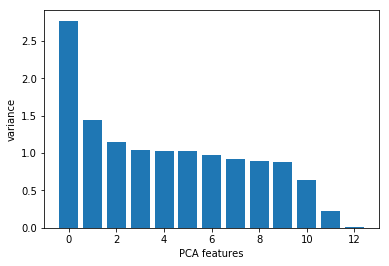

In [236]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA features')
plt.ylabel('variance')
plt.show()

In [237]:
X = PCA(n_components=10).fit_transform(X)

## Train Test & Split

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### DecisionTreeRegressor with GridSearchCV

In [239]:
dtree = DecisionTreeRegressor(random_state=0)

param_grid ={'max_depth' : range(1,10)}

dtree_cv = GridSearchCV(dtree, param_grid, cv=3)
dtree_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [240]:
print("The best param of Decision Tree Regressor:{}".format(dtree_cv.best_params_))
print("The score of Decision Tree Regressor:{}".format(dtree_cv.best_score_))
dtree_cv.best_estimator_

The best param of Decision Tree Regressor:{'max_depth': 1}
The score of Decision Tree Regressor:0.0008800014092720614


DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

## Prediction and scoring

In [241]:
y_pred = dtree_cv.predict(X_test)

In [242]:
print("DecisionTreeRegressor score:{}".format(dtree_cv.score(X_train, y_train)))
print("Mean absolute error:{}".format(mean_absolute_error(y_pred, y_test)))

DecisionTreeRegressor score:0.003642426502410978
Mean absolute error:4.982890910403336
